# 2º Trabalho - Processamento de Sinais Digitais

### Número do Grupo : G04
* Italo Carvalho Vianelli Ribeiro (RA: 769687)
* João Gabriel Viana Hirasawa (RA: 759055)
* Juliana Ferreira Alves (RA: 744794)

In [1]:
import sk_dsp_comm.sigsys as ss
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *

In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 4.0) # default (6,4)
%config InlineBackend.figure_formats=['png'] # default for inline viewing

In [3]:
# Função utilizada nos exemplos
def nextpow2(x):
    '''Retorna o expoente da menor potência de 2 maior do que x.'''
    return 1 if x == 0 else (x - 1).bit_length()

## Convolução acíclica

A convolução cíclica, também conhecida como circular, é a convolução de dois sinais de funções periódicas que possuem o mesmo período. Quando são adicionados zeros o suficiente a direita dos sinais sendo convoluídos, é possível conseguir uma convolução acíclica dentro da convolução cíclica.

O calculo calculo da convolução cíclica pode ser realizado diretamente no domínio do tempo ou no domínio da frequência com a FFT (que é mais rápida). Apesar da FFT ser utilizada para convoluções cíclicas é possível utiliza-lá em convoluções acíclicas adicionando zeros á direita do sinal.

In [4]:
# Convolução acíclica
np.convolve([1,2], [3,4])

array([ 3, 10,  8])

In [5]:
# Convolução acíclica como filter primitive
np.convolve([1,2], [3,4], mode='same')

array([ 3, 10])

In [6]:
# Convolução acíclica como filter primitive e sinal maior
np.convolve([1,2], [3,4,0], mode='same')

array([ 3, 10,  8])

## Convolução acíclica com FFT

In [7]:
# Realizando a FFT dos sinais x e h
x = [1, 2, 3, 4]
h = [1, 1, 1]

nx = len(x)
nh = len(h)
nfft = 2**nextpow2(nx+nh-1)
xzp = x + [0] * (nfft-nx)
hzp = h + [0] * (nfft-nh)
X = np.fft.fft(xzp)
H = np.fft.fft(hzp)

In [8]:
#Saída das FFT de x e h
print('X:')
print(X)

print('H:')
print(H)

X:
[10.        +0.j         -0.41421356-7.24264069j -2.        +2.j
  2.41421356-1.24264069j -2.        +0.j          2.41421356+1.24264069j
 -2.        -2.j         -0.41421356+7.24264069j]
H:
[3.        +0.j         1.70710678-1.70710678j 0.        -1.j
 0.29289322+0.29289322j 1.        +0.j         0.29289322-0.29289322j
 0.        +1.j         1.70710678+1.70710678j]


In [9]:
Y = X * H    # Multiplicação dos termos
y = np.real(np.fft.ifft(Y))    # Transformada inversa de Fourier
yt = y[:nx+nh-1]
yc = np.convolve(x,h)    # Convolução direta apenas para comparar os resultados

In [10]:
print(yt)
print(yc)

[1. 3. 6. 9. 7. 4.]
[1 3 6 9 7 4]


Um exemplo de implementação da convolução por FFT é em aplicações de filtros FIR de áudio digital. Ele é caracterizado por uma resposta ao impulso que após determinado tempo torna-se nula. Em sua implementação para audio digital, é utilizado  uma largura de banda crítica de audicão que define o termo "tempo de integralização", quando o filtro FIR é menor do que este "tempo de integração" o sinal é pesepctivamente instântaneo.

O exemplo a seguir exemplifica esta explicação.

## Exemplo 1: Filtragem passa-baixas por convolução FFT

Neste primeiro exemplo, o objetivo é aplicar um filtro passa-baixas em um sinal $x[n]$ utilizando a FFT.

* $x[n]$ é um sinal de $256$ amostras, composto pelos senoides de frequências $440$, $880$, $1000$ e $2000\ \text{Hz}$.

* A taxa de amostragem $f_s = 5000\ \text{Hz}$ permite que o sinal possa ser amostrado corretamente, já que a maior frequência é de $f_{max} = 2000\ \text{Hz}$ e, assim, $f_s > 2\ f_{max}$.

In [11]:
# Frequências dos senoides do sinal
frequencias = [440, 880, 1000, 2000]

tam_sinal = 256
taxa_amostragem = 5000

# Inicializando o sinal com zeros
x = np.zeros(tam_sinal)

# Criando a variável contador [n]
n = np.arange(0, tam_sinal)

for f in frequencias:
  # Somar o senoide formado por cada frequência
  # e amostrado na taxa determinada
  x += np.sin(2.0 * np.pi * n * f / taxa_amostragem)

Podemos visualizar sinal $x[n]$ por meio do método `stem`:

Text(0, 0.5, 'Amplitude')

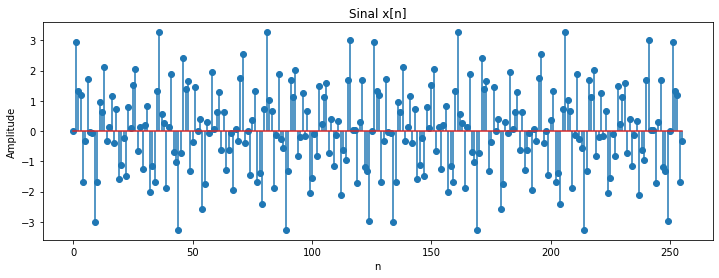

In [12]:
stem(x, use_line_collection=True)
plt.title('Sinal x[n]')
plt.xlabel('n')
plt.ylabel('Amplitude')

E visualizando um pouco mais de perto:

Text(0, 0.5, 'Amplitude')

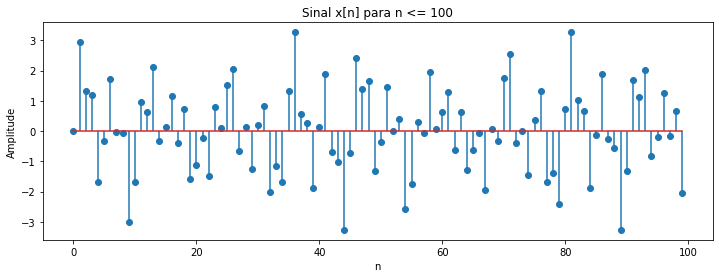

In [13]:
stem(x[:100], use_line_collection=True)
plt.title('Sinal x[n] para n <= 100')
plt.xlabel('n')
plt.ylabel('Amplitude')

Com o sinal definido, agora o filtro é criado pelo método da janela.

* O filtro passa-baixas possui $257$ amostras e a frequência de corte definida como $600\ \text{Hz}$.

In [14]:
tam_filtro = 257
freq_corte = 600
intervalo = (tam_filtro - 1) / 2

# Filtro pelo método da janela
h_sup = np.arange(-intervalo, intervalo+1)
h_ideal = (2.0 * freq_corte / taxa_amostragem) * np.sinc(2.0 * freq_corte * h_sup / taxa_amostragem)

# Aplicar o hamming para suavizar os "cantos" do filtro
h = np.hamming(tam_filtro) * h_ideal

Com isto, também podemos visualizar o filtro (sem e com a aplicação de hamming):

Text(0, 0.5, 'Amplitude')

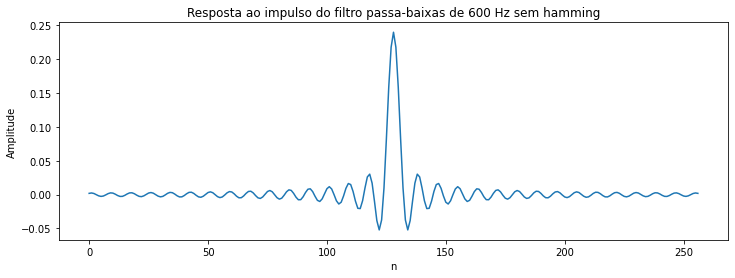

In [15]:
plt.plot(h_ideal)
plt.title('Resposta ao impulso do filtro passa-baixas de 600 Hz sem hamming')
plt.xlabel('n')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

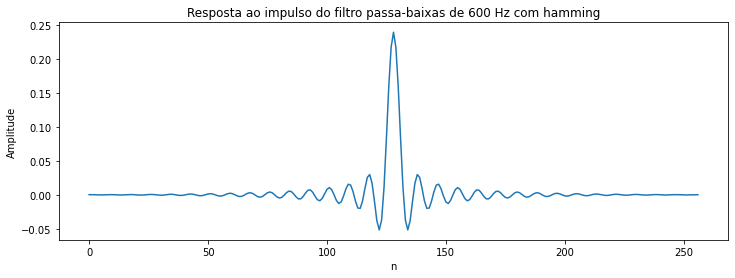

In [16]:
plt.plot(h)
plt.title('Resposta ao impulso do filtro passa-baixas de 600 Hz com hamming')
plt.xlabel('n')
plt.ylabel('Amplitude')

Agora, podemos tomar a FFT dos dois sinais. Para obtenção da convolução acíclica, os sinais são preenchidos com 0 até o tamanho ideal.

In [17]:
# Quantidade de amostras de FFT -- potência de 2
Nfft = 2**nextpow2(tam_sinal+tam_filtro-1)

# Preenchendo com 0 o final da entrada e da resposta
xzp = np.pad(x, (0, Nfft-tam_sinal))
hzp = np.pad(h, (0, Nfft-tam_filtro))

# FFT de cada sinal
X = fftpack.fft(xzp)
H = fftpack.fft(hzp)

Podemos visualizar o espectro de X obtido:

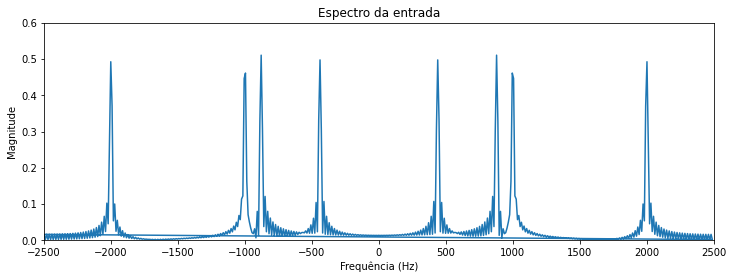

In [18]:
intervalo_frequencias = fftpack.fftfreq(X.size, d=1.0/taxa_amostragem)

plt.plot(intervalo_frequencias, np.abs(X/tam_sinal))
plt.title('Espectro da entrada')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.ylim((0,0.6))
plt.xlim((-2500, 2500))
_ = plt.xticks(np.arange(-2500, 2501, 500))

E também podemos ver a resposta em amplitude do filtro, para entender melhor seu comportamento em relação às frequências:

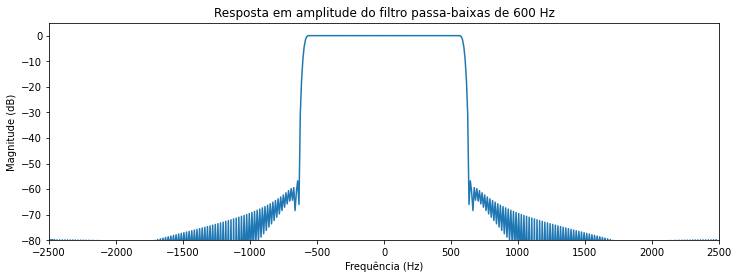

In [19]:
intervalo_frequencias = fftpack.fftfreq(H.size, d=1.0/taxa_amostragem)

plt.plot(intervalo_frequencias, 10*np.log10(np.abs(H)**2))
plt.title('Resposta em amplitude do filtro passa-baixas de 600 Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.ylim(-80, 5)
plt.xlim((-2500, 2500))
_ = plt.xticks(np.arange(-2500, 2501, 500))

Seguindo o teorema da convolução, multiplicamos as transformadas obtidas dos sinais para obter a transformada da saída:

In [20]:
Y = X * H

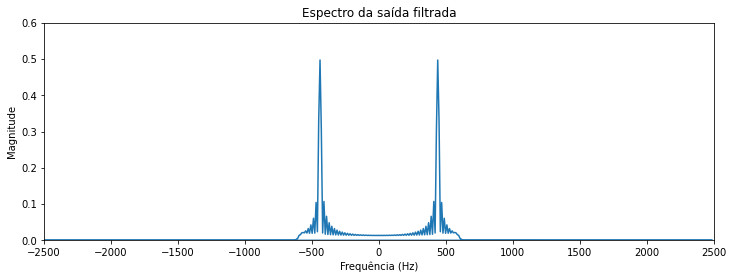

In [21]:
plt.plot(intervalo_frequencias, np.abs(Y/tam_sinal))
plt.title('Espectro da saída filtrada')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.ylim((0, 0.6))
plt.xlim((-2500, 2500))
_ = plt.xticks(np.arange(-2500, 2501, 500))

E então realizando a transformada inversa da saída, podemos obter o sinal convoluído (filtrado):

In [22]:
y = ifft(Y)
relrmserr = np.linalg.norm(np.imag(y)/np.linalg.norm(y))
y = np.real(y)

(0.0, 512.0)

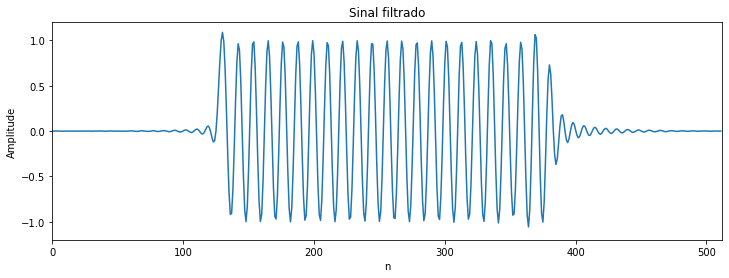

In [23]:
plt.plot(y)
plt.title('Sinal filtrado')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.ylim((-1.2, 1.2))
plt.xlim((0, Nfft))

# Exemplo 2: Aliasing no domínio do tempo

Este próximo exemplo, tem como objetivo verificar o aliasing no domínio do tempo realizando a convolução FFT com extensão de zeros insuficiente. Para a realização desse exemplo foi definido:
* Filtro com L = 65 amostras;
* Tamanho do sinal M = 100, com impulso no tempo 10 e M - (L-1)/4 = 85
* Para evitar aliasing no domínio do tempo devemos utilizar uma FFT com tamanho de pelo menos 85 + 65 - 1 = 149. Assim foi realizado 3 seguintes casos de estudo:  
    1.   Aliasing no tempo forte utilizando uma FFT de tamanho 116
    2.   Aliasing no tempo leve utilizando uma FFT de tamanho 132
    3.   Sem aliasing no tempo utilizando uma FFT de tamanho 165


 


In [24]:
# Tamanho do sinal
tam_sinal = 100
tam_filtro = 65

# Criando a variável contador [n]
n = np.arange(0, tam_sinal)
# Definindo impulsos no tempo 10 e 85
x = ss.dimpulse(n-10) + ss.dimpulse(n-(tam_sinal-(tam_filtro-1)/4))

Podemos visualizar sinal de entrada $x[n]$ por meio do método `stem`:

Text(0.5, 0, 'n')

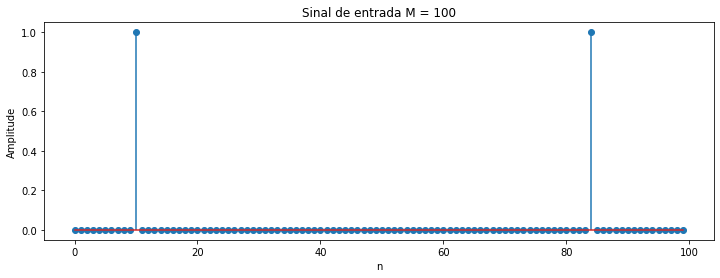

In [25]:
stem(x, use_line_collection=True)
plt.title("Sinal de entrada M = 100")
plt.ylabel("Amplitude")
plt.xlabel("n")

In [26]:
# Frequência de corte
freq_corte = 100
taxa_amostragem = 1000

# Filtro pelo método da janela 
hsupp = np.arange(-(tam_filtro - 1) / 2, 1 + (tam_filtro - 1) / 2)
hideal = (2.0 * freq_corte / taxa_amostragem) * np.sinc(2.0 * freq_corte * hsupp / taxa_amostragem)

# Aplicar o hamming para suavizar os "cantos" do filtro
h = np.hamming(tam_filtro) * hideal

Text(0.5, 0, 'n')

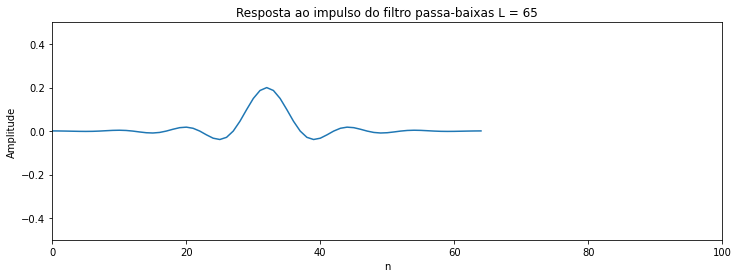

In [27]:
plt.figure(figsize=(12,4))
plt.plot(h)
plt.ylim((-0.5, 0.5))
plt.xlim((0, 100))
plt.title("Resposta ao impulso do filtro passa-baixas L = 65")
plt.ylabel("Amplitude")
plt.xlabel("n")

Primeiramente foi realizado a convolução com aliasing forte no tempo, em que como esperado foi obtido uma resposta em que parte da amostragem do segundo impulso do filtro teve seus valores envoltos, adicionado no inicio do tempo.

Text(0.5, 0, 'Tempo')

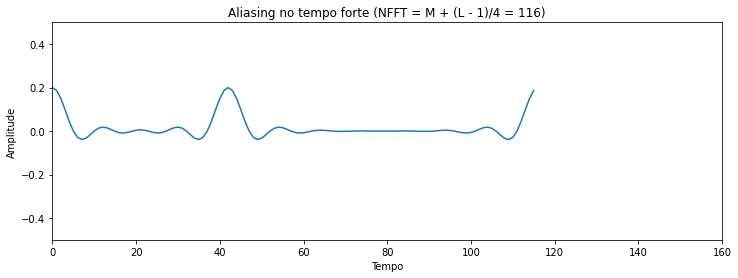

In [28]:
# Definindo tamanho N da fft com valor de M + (L - 1)/4 = 116
Nfft = tam_sinal + (tam_filtro-1)/4

# Preenchendo com 0 o final da entrada e da resposta
xzp = np.pad(x, (0, int(Nfft-tam_sinal)))
hzp = np.pad(h, (0, int(Nfft-tam_filtro)))

# FFT de cada sinal
X = fftpack.fft(xzp)
H = fftpack.fft(hzp)

Y = X * H
y = np.real(fftpack.ifft(Y))

plt.figure(figsize=(12,4))
plt.plot(np.real(y))
plt.ylim((-0.5, 0.5))
plt.xlim((0, 160))
plt.title("Aliasing no tempo forte (NFFT = M + (L - 1)/4 = 116)")
plt.ylabel("Amplitude")
plt.xlabel("Tempo")

Em sequência, foi realizado a convolução com aliasing leve no tempo.

Text(0.5, 0, 'Tempo')

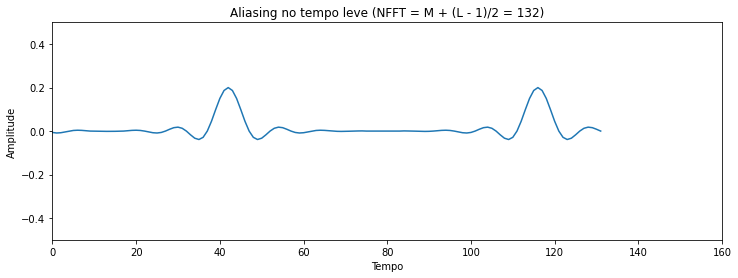

In [29]:
# Definindo tamanho N da fft com valor de M + (L - 1)/2 = 132
Nfft = tam_sinal + (tam_filtro-1)/2

# Preenchendo com 0 o final da entrada e da resposta
xzp = np.pad(x, (0, int(Nfft-tam_sinal)))
hzp = np.pad(h, (0, int(Nfft-tam_filtro)))

# FFT de cada sinal
X = fftpack.fft(xzp)
H = fftpack.fft(hzp)
Y = X * H
y = np.real(fftpack.ifft(Y))

plt.figure(figsize=(12,4))
plt.plot(np.real(y))
plt.ylim((-0.5, 0.5))
plt.xlim((0, 160))
plt.title("Aliasing no tempo leve (NFFT = M + (L - 1)/2 = 132)")
plt.ylabel("Amplitude")
plt.xlabel("Tempo")

E por fim o resultado sem aliasing no tempo.

Text(0.5, 0, 'Tempo')

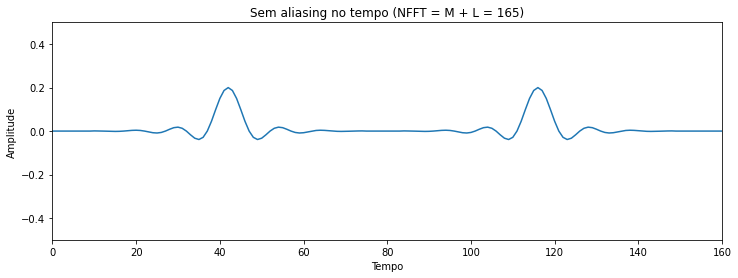

In [30]:
# Definindo tamanho N da fft com valor de M + L = 165
Nfft = tam_sinal + tam_filtro

# Preenchendo com 0 o final da entrada e da resposta
xzp = np.pad(x, (0, int(Nfft-tam_sinal)))
hzp = np.pad(h, (0, int(Nfft-tam_filtro)))

# FFT de cada sinal
X = fftpack.fft(xzp)
H = fftpack.fft(hzp)
Y = X * H
y = np.real(fftpack.ifft(Y))

plt.figure(figsize=(12,4))
plt.plot(np.real(y))
plt.ylim((-0.5, 0.5))
plt.xlim((0, 160))
plt.title("Sem aliasing no tempo (NFFT = M + L = 165)")
plt.ylabel("Amplitude")
plt.xlabel("Tempo")

Os aliasings observados são resultado do tamanho inadequado dos sinais em relação ao tamanho da transformada, na tentativa de realizar uma convolução acíclica. Quando o tamanho chegou ao adequado, ou seja, pelo menos a soma do tamanho dos dois sinais, o aliasing desapareceu.